# Naive RAG

- Author: [Youngjun cho](https://github.com/choincnp)
- Design: [LeeYuChul](https://github.com/LeeYuChul)
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

In this chapter, Section 02(Naive-RAG) through Section 05(Add-Query-Rewrite) is not an independent section, but cover one topic.

We'll make a basic RAG on this section, and make more complicated RAG as sections goes by.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Procedure](#procedure)
- [Creating a Basic PDF-Based Retrieval Chain](#creating-a-basic-pdf-based-retrieval-chain)
- [Defining State](#defining-state)
- [Defining Nodes](#defining-nodes)
- [Creating the Graph](#creating-the-graph)
- [Excuting the Graph](#executing-the-graph)

### References

- [LangGraph Streaming](https://python.langchain.com/docs/concepts/streaming/)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_community",
        "langgraph",
        "typing",
        "langchain-opentutorial"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "02-LangGraph-Naive-RAG",  # set the project name same as the title
        }
    )

## Procedure

Perform `Naive RAG`, the basic RAG system which has 2 progress, **Retrieve** and **Generate** .

You can see the structure in the image below.

![](./assets/02-langgraph-naive-rag.png)

## Creating a Basic PDF-Based Retrieval Chain

This section creates a Retrieval Chain based on a **PDF document** . It is the simplest structure of a Retrieval Chain.

In `LangGraph` , Retrievers and Chains are created separately. This allows detailed processing for each node.

In [4]:
from rag.pdf import PDFRetrievalChain

# Load the PDF document
pdf = PDFRetrievalChain(["data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf"]).create_chain()

# Create retriever and chain
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

First, use the `pdf_retriever` to fetch search results.

You can control the quantity to retrieve, by changing `self_k` argument in `pdf.py` file.

In [5]:
search_result = pdf_retriever.invoke(
    "Where has the application of AI in healthcare been confined to so far?"
)
search_result

[Document(id='76d10387-a006-4d7c-8bd1-c316831d6094', metadata={'source': 'data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf', 'file_path': 'data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf', 'page': 14, 'total_pages': 24, 'CreationDate': "D:20200922223534+02'00'", 'Creator': 'Adobe InDesign 15.1 (Macintosh)', 'ModDate': "D:20200922223544+02'00'", 'Producer': 'Adobe PDF Library 15.0', 'Trapped': 'False'}, page_content='activities. So far, however, AI applications in healthcare have been potential. Specific healthcare training should be provided to data\nconfined to administrative tasks (i.e., Natural Language Processing scientists working in hospitals so that they can better understand'),
 Document(id='f4f78deb-c8d9-4c84-a3e4-a91b0477413d', metadata={'source': 'data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf', 'file_path': 'data/A European Approach to Artificial Intelligence - A Policy Perspective.

Pass the search result as context to the chain.

In [6]:
# Generate an answer based on the search results
answer = pdf_chain.invoke(
    {
        "question": "Where has the application of AI in healthcare been confined to so far?",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

The application of AI in healthcare has so far been confined primarily to administrative tasks, such as Natural Language Processing for extracting information from clinical notes and predictive scheduling. There is potential for more extensive use in research and development, but significant applications remain limited.

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (page 14)


## Defining State

`State` defines the **shared state** among the nodes and another nodes.

Typically, the `TypedDict` format is used.

In [7]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

# Define GraphState
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # Question
    context: Annotated[str, "Context"]  # Search results from the document
    answer: Annotated[str, "Answer"]  # Answer
    messages: Annotated[list, add_messages]  # Messages (accumulated list)

## Defining Nodes

`Nodes` : These are nodes that handle each stage, typically implemented as Python functions. Inputs and outputs are the State values.

[ **Note** ]  
- A `State` is taken as input, performs the defined logic, and returns an **updated** `State` .

In [8]:
from rag.utils import format_docs
from langchain_opentutorial.messages import messages_to_history

# Node that retrieve document
def retrieve_document(state: GraphState) -> GraphState:
    # Get the question from the state
    latest_question = state["question"]

    # Search the document to find relevant sections
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # Format the retrieved documents (to input into a prompt)
    retrieved_docs = format_docs(retrieved_docs)
    
    # Save the retrieved documents in the key named context
    return {"context": retrieved_docs}


# Node that generate answer
def llm_answer(state: GraphState) -> GraphState:
    # Get the question from the state
    latest_question = state["question"]

    # Get the retrieved documents from the state
    context = state["context"]

    # Call the chain to generate an answer
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    # Save the generated answer and (user question, answer) messages in the state
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

## Creating the Graph

`Edges` : Python functions that determine the next `Node` to execute based on the **current** `State` .

There can be general edges and conditional edges.

In [9]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Create a graph
workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# Define edges
workflow.add_edge("retrieve", "llm_answer")  # Retrieval -> Answer generation
workflow.add_edge("llm_answer", END)  # Answer generation -> End

# Set entry point for the graph
workflow.set_entry_point("retrieve")

# Set up a checkpointer
memory = MemorySaver()

# Compile the graph
app = workflow.compile(checkpointer=memory)

Visualize the compiled graph.

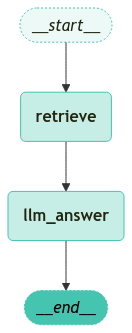

In [10]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app) 

## Executing the Graph

- The `config` parameter provides configuration informations necessary for graph execution.
- `recursion_limit` : Sets the maximum recursion depth for graph execution.
- `inputs` : Provides the input data for the graph execution.

The `stream_graph` function below streams only specific nodes.

You can easily check the **streaming output** of a **specific node** .

In [11]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import invoke_graph, stream_graph, random_uuid

# Configure settings (recursion limit, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# Question input
inputs = GraphState(
    question="Where has the application of AI in healthcare been confined to so far?"
)

# Execute the graph
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>activities. So far, however, AI applications in healthcare have been potential. Specific healthcare training should be provided to data
confined to administrative tasks (i.e., Natural Language Processing scientists working in hospitals so that they can better understand</content><source>data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf</source><page>15</page></document>
<document><content>are great, as more use of AI in research and development could
Healthcare is arguably the sector where AI could make the lead to a more personalised healthcare based on patients’ data.</content><source>data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf</source><page>15</page></document>
<document><content>intermediate / professional users (i.e., healthcare professionals). the safety of employees. The key application of AI is certainly in
This is a 

In [12]:
# Stream the graph outputs
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
The application of AI in healthcare has so far been confined primarily to administrative tasks, such as Natural Language Processing for extracting information from clinical notes and predictive scheduling.

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (page 15)

In [13]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: Where has the application of AI in healthcare been confined to so far?
Answer:
The application of AI in healthcare has so far been confined primarily to administrative tasks, such as Natural Language Processing for extracting information from clinical notes and predictive scheduling.

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (page 15)
